In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

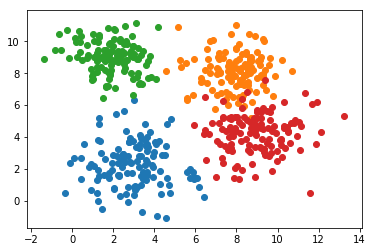

In [2]:
def createDataset(k, means, std, size=500):
    data = np.empty( (0,3) )
    for cluster in range(k):
        pts = np.random.normal(means[cluster], std[cluster], size=(size//k,2))
        pts = np.c_[pts, np.ones(size//k)*cluster ]
        data = np.append( data, pts, axis=0)
    np.random.shuffle(data)
    return data
data = createDataset( 4, [ (3,2), (8,8), (2,9), (9,4) ], [ 1.5, 1.1, 1, 1.4] )
for k in range(4):
    temp = data[:,0:2][data[:,2]==k]
    plt.scatter( temp[:,0], temp[:,1],  )

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split( data[:,0:2],data[:,2],test_size=0.2, stratify=data[:,2] )
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((400, 2), (100, 2), (400,), (100,))

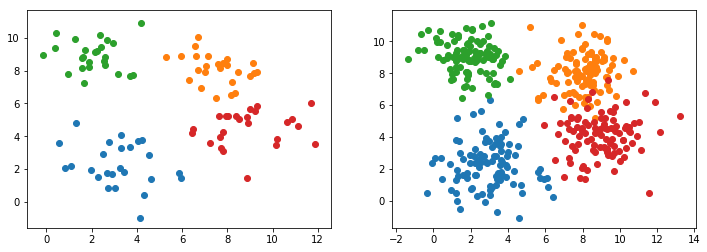

In [4]:
#our test data
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
for k in range(4):
    temp = X_test[Y_test==k]
    ax[0].scatter( temp[:,0], temp[:,1] )
for k in range(4):
    temp = X_train[Y_train==k]
    ax[1].scatter( temp[:,0], temp[:,1],  )

### DBSCAN - Density based spartial clustering of applications with Noise

> DBSCAN is a well-known data clustering algorithm that is commonly used in data mining and machine learning. DBSCAN groups together points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions.

> Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

> There are 3 types of points in sample
1. **Core Points**: A data point p is a core point if  within [ɛ-neighborhood of p] contains at least minPts.
2. **Border Points**: A data point q is a border point if within [ɛ-neighborhood of p] contains less than minPts data points, but q is reachable from some core point p.
3. **Outlier**: A data point o is an outlier if it is neither a core point nor a border point. Essentially, this is the “other” class.

> **Algorithm**
1. Find index of core points.
2. For each core point
    * continue if core is assigned cluster
    * assign a new cluster label to this core point
    * assign same cluster label to ɛ-neighbor core points repeatedly untill no new core points are in ɛ-neighborhood 
3. For each point(p), find total number of points in each cluster group within [ɛ-neighborhood of p]
4. Assign cluster label to p with maximum core nodes in neighbor and if it there are no cores it is outlier.

> **Article**: [Nice Article](https://blog.dominodatalab.com/topology-and-density-based-clustering/), [Nice Article](https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818)

In [5]:
def euclidean(X1,X2):
    return  np.sqrt(np.sum((X1-X2)**2, axis=1))

In [6]:
min_points = 10
eps = 0.7

In [7]:
cores = []
for sample in X_train:
    cores.append((euclidean(X_train,sample) < eps).sum() >= min_points)
cores = np.where(cores)[0]
cores, len(cores)

(array([  0,   2,   8,  12,  14,  15,  18,  19,  26,  27,  28,  30,  31,
         32,  35,  36,  38,  40,  42,  51,  52,  54,  56,  60,  64,  65,
         66,  68,  69,  71,  72,  74,  76,  78,  79,  83,  85,  87,  89,
         92,  94,  95,  98, 102, 103, 106, 107, 108, 109, 110, 111, 112,
        115, 122, 123, 127, 129, 131, 132, 135, 136, 138, 139, 141, 142,
        143, 144, 145, 146, 147, 148, 152, 153, 154, 157, 158, 160, 165,
        168, 169, 171, 176, 179, 181, 182, 183, 187, 189, 193, 196, 197,
        198, 199, 200, 201, 203, 208, 211, 215, 216, 218, 219, 225, 227,
        231, 235, 236, 237, 241, 245, 249, 253, 254, 255, 256, 257, 260,
        263, 266, 267, 268, 270, 271, 275, 276, 282, 284, 285, 286, 287,
        291, 292, 294, 295, 296, 298, 299, 301, 302, 303, 307, 308, 313,
        314, 315, 316, 319, 322, 324, 331, 333, 336, 337, 338, 339, 340,
        341, 348, 349, 350, 351, 354, 359, 361, 362, 363, 364, 368, 369,
        372, 374, 375, 378, 380, 382, 383, 388, 389

Text(0.5,1,'Cores')

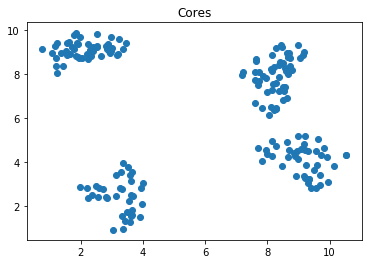

In [8]:
temp = X_train[cores]
plt.scatter( temp[:,0], temp[:,1],  )
plt.title('Cores')

In [9]:
clusters = []
cluster_index = np.ones( (len(X_train),), dtype=np.int )*-1
curr_index = 0
for i in cores:
    if cluster_index[i]!=-1: continue
    clusters.append( [i]  )
    cluster_index[i] = curr_index;
    new = { i }
    while len(new)>0:
        pt = X_train[new.pop()]
        indexes = np.where( ((euclidean(X_train,pt) < eps) & (cluster_index==-1)) )[0]
        for index in indexes:
            if index not in cores: continue
            new.add(index)
            clusters[ curr_index ].append( index )
            cluster_index[index] = curr_index
    curr_index+=1
len(clusters) 

4

In [10]:
clusters = [ np.array([  X_train[index] for index in cluster ]) for cluster in clusters ]
for c in clusters: print(c.shape)

(43, 2)
(49, 2)
(54, 2)
(36, 2)


In [11]:
labels_ = []
for index in range( len(X_train) ):
    dists = [  ]
    for cluster in clusters:
        dists.append( (euclidean(cluster, X_train[index])<eps).sum() )
    cls = np.argmax(dists)
    labels_.append( cls if dists[cls]!=0 else -1 )

In [12]:
np.unique(labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([127,  68,  71,  77,  57]))

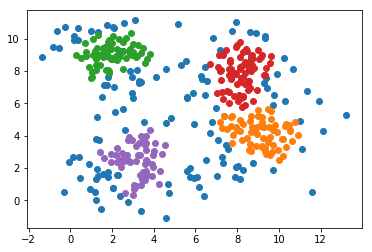

In [13]:
for k in np.unique(labels_):
    temp = X_train[labels_==k]
    plt.scatter( temp[:,0], temp[:,1])